In [100]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.optim as optim 
import tushare as ts 

In [101]:
"""
ts.set_token('33c8fbd10a7b6a4a6693248c188516c8c48804997be46bea6d54acaa')
ts_pro = ts.pro_api()
# 股票代码
ts_code = 'APPL'
# 开始时间
start_date = '20100101'
# 结束时间
end_date = '20200101'
df = ts_pro.us_daily(
        ts_code=ts_code,
        start_date=start_date,
        end_date=end_date)
# 将获取的文件存储在本地
df.to_csv('AAPL.csv', index=0)
df.head()
"""

"\nts.set_token('33c8fbd10a7b6a4a6693248c188516c8c48804997be46bea6d54acaa')\nts_pro = ts.pro_api()\n# 股票代码\nts_code = 'APPL'\n# 开始时间\nstart_date = '20100101'\n# 结束时间\nend_date = '20200101'\ndf = ts_pro.us_daily(\n        ts_code=ts_code,\n        start_date=start_date,\n        end_date=end_date)\n# 将获取的文件存储在本地\ndf.to_csv('AAPL.csv', index=0)\ndf.head()\n"

In [102]:
"""
df = pd.read_csv('./APPL.csv')
# 按照时间进行排序，方便预测处理
df = df.sort_values(['trade_date'], ascending=True)
# 简要查看文件信息
df.to_csv('./APPL.csv', index=0)
df.head()
"""

"\ndf = pd.read_csv('./APPL.csv')\n# 按照时间进行排序，方便预测处理\ndf = df.sort_values(['trade_date'], ascending=True)\n# 简要查看文件信息\ndf.to_csv('./APPL.csv', index=0)\ndf.head()\n"

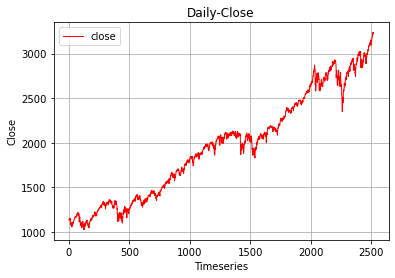

In [103]:
s_data = pd.read_csv('./Data/SPX.csv', parse_dates=True)
s_data_copy = s_data
t = 3000
plt.plot(s_data["close"][:t],'r',lw = 1)
plt.legend(["close"])
plt.grid(True)
plt.axis("tight")
plt.xlabel("Timeseries")
plt.ylabel("Close")
plt.title("Daily-Close")
plt.savefig('SPX.png')
plt.show()

In [118]:
#定义训练集
data_csv = pd.read_csv('./data/399001.SZ.csv')
use_cols = ['close']
data_csv = data_csv [use_cols]
data_csv = data_csv.dropna()
# 为了归一化后复现原来数据
close_min = data_csv['close'].min()
close_max = data_csv['close'].max()
# 归一化处理（0，1）
data_csv=data_csv.apply(lambda x:(x-min(x))/(max(x)-min(x)))
data_csv.head()

close
0  0.588765
1  0.587309
2  0.586211
3  0.561914
4  0.564793

In [119]:
import numpy as np 
# 序列长度为5，即用前5的数据预测之后一天的数据
sequence = 30
X = []
Y = []
for i in range(data_csv.shape[0]-sequence):
    # 选择use_cols作为特征
    X.append(np.array(data_csv.iloc[i:(i+sequence)].values, dtype=np.float))
    # 选择close作为标签输出
    Y.append(np.array(data_csv.iloc[(i+sequence)],dtype=np.float))

In [120]:
trainx, trainy = X[:int(0.7*data_csv.shape[0])], Y[:int(0.7*data_csv.shape[0])]
testx, testy = X[int(0.7*data_csv.shape[0]):], Y[int(0.7*data_csv.shape[0]):]

print(len(trainx))
print(len(testx))

1701
700


In [121]:
torch.manual_seed(1)

In [122]:
# list -> numpy
trainx = np.array(trainx)
trainy = np.array(trainy)
testx = np.array(testx)
testy = np.array(testy)

trainx = trainx.astype('float32')
trainy = trainy.astype('float32')
testx = testx.astype('float32')
testy = testy.astype('float32')


print(trainx.shape)
print(trainy.shape)
print(testx.shape)
print(testy.shape)


# model size (seq_size, batch_size, feature_size)
trainx = trainx.reshape(-1,1, sequence )  # (seq_size, batch_size, feature_size)
trainy = trainy.reshape(-1,1, 1)
testx = testx.reshape(-1, 1, sequence) 


# numpy -> torch
trainx = Variable(torch.from_numpy(trainx))
trainy = Variable(torch.from_numpy(trainy))
testx = Variable(torch.from_numpy(testx))


print('trainx size: ', trainx.size())
print('trainy size: ', trainy.size())
print('testx size: ', testx.size())

(1701, 30, 1)
(1701, 1)
(700, 30, 1)
(700, 1)
trainx size:  torch.Size([1701, 1, 30])
trainy size:  torch.Size([1701, 1, 1])
testx size:  torch.Size([700, 1, 30])


In [123]:
class RNN(nn.Module):
    def __init__(self,in_feature,hidden_size,n_class):
        super(RNN, self).__init__()
        self.in_feature = in_feature
        self.hidden_size = hidden_size
        self.n_class = n_class
        self.in2hidden = nn.Linear(self.in_feature+self.hidden_size,self.hidden_size)
        self.hidden2out = nn.Linear(self.hidden_size,self.n_class)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    ##此处input的尺寸为[seq_len,batch,in_feature]
    def forward(self,input,pre_state):
        T=input.shape[0]
        batch=input.shape[1]
        a = Variable(torch.zeros(T,batch,self.hidden_size))             #a-> [T,hidden_size]
        o = Variable(torch.zeros(T,batch,self.n_class))                 #o ->[T,n_class]
        predict_y = Variable(torch.zeros(T,batch,self.n_class))
        # pre_state = Variable(torch.zeros(batch, self.hidden_size))  # pre_state=[batch,hidden_size]


        if pre_state is None:
            pre_state = Variable(torch.zeros(batch, self.hidden_size)) # hidden ->[batch,hidden_size]

        for t in range(T):
            # input:[T,batch,in_feature]
            tmp = torch.cat((input[t], pre_state), 1) #  [batch,in_feature]+[batch,hidden_size]-> [batch,hidden_size+in_featue]
            a[t] = self.in2hidden(tmp)                  #  [batch,hidden_size+in_feature]*[hidden_size+in_feature,hidden_size] ->[batch,hidden_size]
            hidden = self.tanh(a[t])

            #这里不赋值的话就没有代表隐层向前传递
            pre_state = hidden

            o[t] = self.hidden2out(hidden)  # [batch,hidden_size]*[hidden_size,n_class]->[batch,n_class]
            #由于此次是一个单分类问题，因此不用softmax函数
            if self.n_class ==1:
                predict_y[t] = torch.sigmoid(o[t])
            else:
                predict_y[t] = self.softmax(o[t])

        return predict_y, hidden

In [124]:
input_size = 30      #一个序列的长度,也就是输入特征数
n_hidden = 30      #隐层神经元数目
target_size = 1     #输出的尺寸

In [125]:
model = RNN(in_feature=input_size,hidden_size=n_hidden,n_class=target_size)
print(model)

RNN(
  (in2hidden): Linear(in_features=60, out_features=30, bias=True)
  (hidden2out): Linear(in_features=30, out_features=1, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)


In [126]:
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_fun=nn.MSELoss()

In [127]:
num_epoch=100
# print(len(train_x))
#
for epoch in range(num_epoch):
    state=None
    out, state = model(trainx, state)
    loss=loss_fun(out,trainy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:  # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(epoch + 1, loss.item()))
    # state = None
    # #

Epoch: 10, Loss: 0.05804
Epoch: 20, Loss: 0.05265
Epoch: 30, Loss: 0.04645
Epoch: 40, Loss: 0.03585
Epoch: 50, Loss: 0.02053
Epoch: 60, Loss: 0.00827
Epoch: 70, Loss: 0.00699
Epoch: 80, Loss: 0.00523
Epoch: 90, Loss: 0.00473
Epoch: 100, Loss: 0.00423


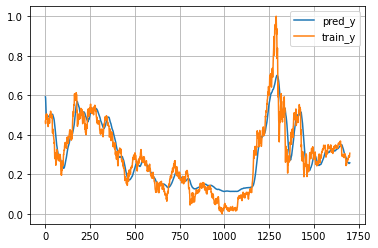

In [129]:
model = model.eval() # 让model变成测试模式（训练效果图）
hidden1=None
out2,_=model(trainx,hidden1)
plt.plot(out2.data.numpy().reshape(1701,1), label='pred_y')
plt.plot(trainy.reshape(1701,1), label='train_y')
plt.grid(True)
plt.axis("tight")
plt.legend()
plt.show()

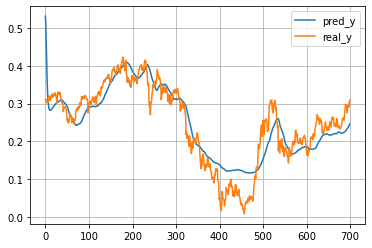

In [131]:
# 测试集输入模型进行预测
model = model.eval() 
hidden2 = None
out3,_ = model(testx,hidden2)
plt.plot(out3.data.numpy().reshape(700,1),label='pred_y')
plt.plot(testy.reshape(700,1),label='real_y')
plt.legend()
plt.grid(True)
plt.axis("tight")
plt.savefig("RNN-Tanh-Prediction(SZSE).png")
plt.show()

In [134]:
pred = out3.data.numpy().reshape(700,1)
real = testy.reshape(700,1)
print(pred.shape)
print(real.shape)

(700, 1)
(700, 1)


In [135]:
mse = mean_squared_error(pred, real)
rmse = math.sqrt(mean_squared_error(pred, real))
mae = mean_absolute_error(pred, real)
print('mean_squared_error: %.6f' % mse)
print('root_mean_squared_error: %.6f' % rmse)
print('mean_absolute_error: %.6f' % mae)

mean_squared_error: 0.001936
root_mean_squared_error: 0.043996
mean_absolute_error: 0.034839
